In [1]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegem1d import (
    GlobalEM1DProblem, GlobalEM1DSurveyFD, get_vertical_discretization
)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Seting up a 2D mesh and model

In [2]:
frequency = np.array([900, 7200, 56000], dtype=float)
hz = get_vertical_discretization(frequency, sigma_background=0.01)

167.7640403482901


In [3]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

In [4]:
n_sounding = 20
dx = 20.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
inds_1 =  mesh.gridCC[:,1]<50
sigma = np.ones(mesh.nC) * 1./100.
sigma[inds_1] = 1./10.
sigma[inds] = 1./50.
x0 = np.r_[0., 75.]
x1 = np.r_[400., 75.]
x2 = np.r_[400., 90.]
x3 = np.r_[0., 125.]
pts = np.vstack((x0, x1, x2, x3, x0))
# poly_inds = PolygonInd(mesh, pts)
# sigma[poly_inds] = 0.1
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()

In [23]:
sigma_em1d.reshape((n_sounding, FDsurvey.n_layer)).shape

(20, 19)

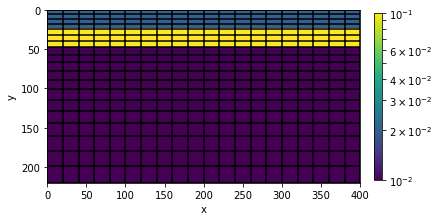

In [5]:
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=True, pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.025, pad=0.04    
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect('equal')

In [6]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

In [7]:
mapping = Maps.ExpMap(mesh)
# mapping = Maps.IdentityMap(mesh)

In [8]:
survey = GlobalEM1DSurveyFD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    frequency = frequency,
    offset = np.ones_like(frequency) * 8.,
    src_type = "VMD",
    rx_type = "Hz",
    field_type = 'secondary',
    topo = topo
)
prob = GlobalEM1DProblem([], sigmaMap=mapping, hz=hz)
prob.pair(survey)

In [9]:
m = np.log(sigma_em1d)
pred = survey.dpred(m)

In [10]:
sigma_em1d.reshape((prob.n_sounding, prob.n_layer))[0,:]

array([0.02, 0.02, 0.02, 0.02, 0.1 , 0.1 , 0.1 , 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [11]:
# m = sigma.copy()

In [12]:
J = prob.getJ(m)

In [13]:
from SimPEG import Utils

In [14]:
Jv = prob.Jvec(m, m)

In [15]:
Jtv = prob.Jtvec(m, pred)

In [16]:
Jtv[:19]

array([ 5.69131087e-26,  2.09763469e-26,  4.09790308e-27, -1.57323912e-28,
        3.66072056e-29, -2.20979409e-29, -4.41160057e-28, -2.96291123e-29,
       -1.60399868e-29, -7.10866084e-30, -2.02619294e-30,  2.21398767e-31,
        6.41628482e-31,  1.29820319e-31, -6.28723551e-31, -1.21725903e-30,
       -1.47486881e-30, -1.42477770e-30, -3.04189433e-30])

In [17]:
Jv[:6]

array([8.50782132e-14, 2.15298878e-13, 6.79208051e-13, 9.56066705e-14,
       1.90867062e-13, 6.85574939e-14])

In [18]:
pred = survey.dpred(m)

In [19]:
from simpegem1d import EM1DSurveyFD, EM1D, run_simulation_FD
mesh_1d = Mesh.TensorMesh([mesh.hy], x0=[0.])
depth = -mesh_1d.gridN[:-1]
m_1d = np.log(prob.Sigma[0,:])
# m_1d = prob.Sigma[0,:]
FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 30.]),
    src_location = np.array([0., 0., 30.]),
    field_type = 'secondary',
    rx_type = 'Hz',
    src_type = 'VMD',
    depth = depth,
    topo = np.r_[0., 0., 0.],
    frequency = survey.frequency.copy(),
    offset = 8. * np.ones(3)
)
prob_1d = EM1D(
    mesh_1d, sigmaMap=Maps.ExpMap(mesh_1d), jacSwitch=True
)
if prob_1d.ispaired:
    prob_1d.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob_1d.pair(FDsurvey)
Hz = FDsurvey.dpred(m_1d)
dummy, dHzdsig = prob_1d.fields(m_1d)
J_Hz = FDsurvey.projectFields(dHzdsig)
Jv_Hz = prob_1d.Jvec(m_1d, m_1d)
Jtv_Hz = prob_1d.Jtvec(m_1d, Hz)

In [31]:
Jv_Hz-Jv[:6]

array([-3.30988368e-14, -2.27058991e-14,  6.11879760e-15, -2.09520415e-14,
        2.87870176e-14, -5.09716465e-17])

In [32]:
istart = 38
Jtv_Hz-Jtv[istart:istart+19]

array([ 1.14794370e-41,  0.00000000e+00,  7.17464814e-43,  4.48415509e-44,
        7.84727140e-44, -6.72623263e-44,  0.00000000e+00, -5.60519386e-45,
       -2.80259693e-45, -2.80259693e-45, -3.50324616e-46,  2.18952885e-46,
        3.50324616e-46, -9.19602117e-46,  1.75162308e-46, -1.75162308e-46,
        0.00000000e+00, -3.50324616e-46,  0.00000000e+00])

In [21]:
test_jvec = prob.Jvec(m, np.ones(mesh.nC))

In [22]:
test_jvec[:6]

array([-3.02086797e-14, -6.08393092e-14, -1.72056568e-13, -2.97949966e-14,
       -4.14312605e-14, -1.75378482e-14])

In [35]:
test_jvec[6:12]

array([-3.17569233e-15, -2.14758363e-15, -8.59951910e-16, -3.11806113e-16,
        9.48058005e-16,  6.54531680e-16])

In [34]:
test

array([-3.02086797e-14, -6.08393092e-14, -1.72056568e-13, -2.97949966e-14,
       -4.14312605e-14, -1.75378482e-14])

In [18]:
# Hz_r = Hz.reshape((2, survey.n_frequency))[0,:]
# Hz_i = Hz.reshape((2, survey.n_frequency))[1,:]

In [17]:
PRED = pred.reshape(( prob.n_sounding, 2, survey.n_frequency))
Hz_pred_r = PRED[0,0,:]
Hz_pred_i = PRED[0,1,:]

In [14]:
print (Hz_pred_r)
print (Hz_r)

[-2.68337265e-14 -1.27714505e-13 -3.64089249e-13]
[-2.68337265e-14 -1.27714505e-13 -3.64089249e-13]


In [15]:
print (Hz_pred_i)
print (Hz_i)

[-5.10077483e-14 -1.14085681e-13 -2.20704132e-13]
[-5.10077483e-14 -1.14085681e-13 -2.20704132e-13]


In [16]:
rx_location = FDsurvey.rx_location
src_location = FDsurvey.src_location
topo = FDsurvey.topo
hz = mesh.hy
offset = FDsurvey.offset
frequency = FDsurvey.frequency
field_type = FDsurvey.field_type
rx_type = FDsurvey.rx_type
src_type = FDsurvey.src_type
sigma = prob_1d.sigma
jacSwitch = False
args = rx_location, src_location, topo, hz, offset, frequency, field_type, rx_type, src_type, sigma, jacSwitch
Hz_sim = run_simulation_FD(args)

In [17]:
FDsurvey.depth

array([  -0.        ,   -5.31699347,  -11.05966405,  -17.26209133,
        -23.96108332,  -31.19639487,  -39.01096356,  -47.45116459,
        -56.5670859 ,  -66.4128255 ,  -77.04681243,  -88.53215359,
       -100.93700816, -114.33499214, -128.80561523, -144.43475262,
       -161.31515467, -179.5469973 , -199.23847649])

In [18]:
args

(array([ 0.,  0., 30.]),
 array([ 0.,  0., 30.]),
 array([0., 0., 0.]),
 array([ 5.31699347,  5.74267058,  6.20242728,  6.69899199,  7.23531154,
         7.8145687 ,  8.44020103,  9.11592132,  9.8457396 , 10.63398694,
        11.48534115, 12.40485457, 13.39798399, 14.47062309, 15.62913739,
        16.88040205, 18.23184263, 19.69147919, 21.26797387]),
 array([8., 8., 8.]),
 array([  900.,  7200., 56000.]),
 'secondary',
 'Hz',
 'VMD',
 array([0.02, 0.02, 0.02, 0.02, 0.1 , 0.1 , 0.1 , 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
 False)

In [19]:
Hz_sim_r = Hz_sim.reshape((2, survey.n_frequency))[0,:]
Hz_sim_i = Hz_sim.reshape((2, survey.n_frequency))[1,:]

In [20]:
print (Hz_sim_r)
print (Hz_sim_i)

[-2.68337265e-14 -1.27714505e-13 -3.64089249e-13]
[-5.10077483e-14 -1.14085681e-13 -2.20704132e-13]


In [21]:
# plt.loglog(FDsurvey.frequency, -hz.reshape((2, 3))[0,:])
# plt.loglog(FDsurvey.frequency, -hz.reshape((2, 3))[1,:])
# plt.loglog(FDsurvey.frequency, -hz_pred_r)
# plt.loglog(FDsurvey.frequency, -hz_pred_i)